###  Searching for exoplanets in a dataset of 1699 stars

This is a continuation of the previous posts in which I described how I used the Lomb-Scargle periodogram to search for periodic fluctuations in the motions of stars. If a star displays some regular variation in its line-of-sight velocity, there's a good chance it may host one or more planets. To tidy up the ipython notebook, I created a module named `exoplanet_rvfit` in which the periodograms and plots can be quickly created by calling their respective functions. You can check out the code on [the Github repository for this project.](https://github.com/AnnaKwa/Keck_RVs/)

In [1]:
%matplotlib inline
from exoplanet_rvfit import *
import pickle

/home/anna/anaconda3/envs/conda3_env/lib/python3.6/site-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/anna/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


### Checking to make sure functions are working as expected
Now I'll just test the functions on one star to show what they do. 

Best-fitting periods:
P= 0.260899466573  days , power= 0.913418924292
P= 1.81634096714  days , power= 0.904483172669
P= 0.274584097529  days , power= 0.897759160551


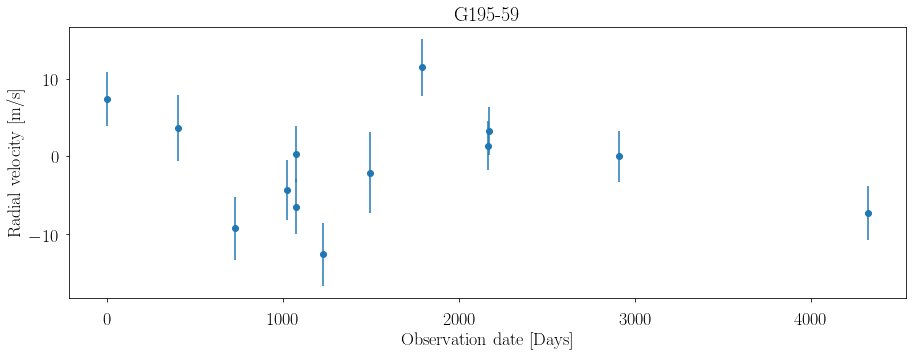

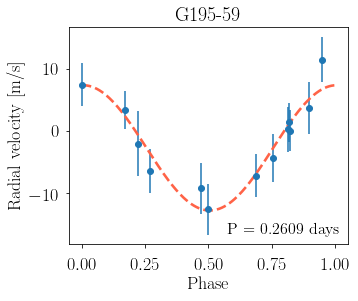

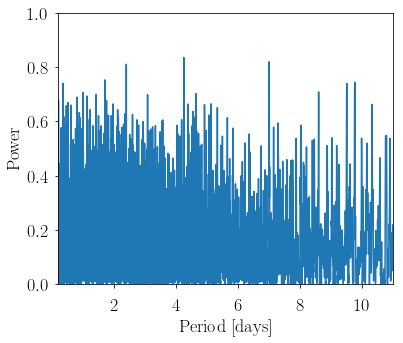

In [12]:
teststar = Star('G195-59', data_dir='/home/anna/Desktop/self_teaching/blog/data/Keck_RVs/')

teststar.find_period(min_period=0.2, max_period=11, print_output=True)
teststar.plot_raw_RVs()
teststar.plot_phased_RVs(num_plots=1)
teststar.find_periodogram(Nperiods=10000, plot=True)


### Now repeat this for all 1699 stars in the dataset...

I only need to run the code below once, and then it will write results of the analysis for each star to a file.

In [9]:
# import list of all stars in catalog

with open('/home/anna/Desktop/self_teaching/blog/data/Keck_RVs/Keck_catalog.txt') as temp_file:
    starIDs= [line.rstrip('\n') for line in temp_file]
print (repr(len(starIDs)),' stars with Keck HIRES high-precision data')
numStars=len(starIDs)

# record candidate detections into a pickle

star_dtypes=np.dtype( [('name','S10'),('period',float),('power',float),('amplitude',float),('phase',float),('offset',float)] )


print('Record array dtypes: Star / Orbital period [days] / Power / Amplitude [m/s] / Phase shift [rad] / Offset [m/s]')
print('Amplitude, phase, and offset are fit to phase-folded data (freq=2 Pi)')

candidate_count=0

for s in range(numStars):
    star = Star(starIDs[s], data_dir='/home/anna/Desktop/self_teaching/blog/data/Keck_RVs/')
    
    # check that num data points > min_num_obs 
    min_number_obs = 8
    if star.N < min_number_obs:
        continue
        
    print(s,'/',numStars, 'stars, ',candidate_count,' host candidates')
    # set threshold for detection peak
    min_detection_threshold_power = 0.8
    star.find_period(num_best_fits=1, min_period=0.2, max_period=11, print_output=False)
    P, power = star.best_periods[0][0], star.best_periods[1][0]
    
    # move on if best period has score below threshold for detection
    if power < min_detection_threshold_power:
        continue
        
    # find best-fitting sine function to phase folded data A*sin(x+c)+b
    candidate_count+=1
    fit_params = star.fit_to_sine(fitNum=0)
    A, c, b = fit_params[0], fit_params[1], fit_params[2]

    if s==0:
        results=np.array( [(starIDs[s], P, power, A, c, b)], dtype = star_dtypes)
     
    else:
        results = np.append(results, np.array( [(starIDs[s], P, power, A, c, b)], \
                                              dtype = star_dtypes)

outfile = open('/home/anna/Desktop/self_teaching/projects/Keck_radial_vel/results.p', 'wb')        
pickle.dump(results, outfile)

1698


### Examining the results for the entire dataset

Now that we've done the periodogram analysis for all the stars in the dataset, we can look at the results to find out how many stars are candidates to host a hot Jupiter type exoplanet.

In [46]:
picklefile='/home/anna/Desktop/self_teaching/projects/Keck_radial_vel/results.p'
results=pickle.load(open(picklefile,"rb"))
results=results.view(np.recarray)

Out of the 1699 stars examined, 311 show evidence for radial velocity variations at some period that has power greater than 0.9. We'll call these stars candidate hosts for exoplanets.

In [79]:
candidate_stars = results[ results['power']>0.9]
print(len(candidate_stars))

311


Planets aren't the only objects that can cause stars to "wobble"--a binary star system would also display variations in each star's radial velocity, but at a higher amplitude. I'll be cautious and eliminate stars with amplitudes above 100 m/s from the list of candidate planet hosts as they are likely to be members of a binary system. There are 85 such stars, which leaves  226 stars from the original sample as potential hosts for exoplanets. Not bad!

In [91]:
highAmplitude_stars = results[ results['amplitude']>100]
print(len(highAmplitude_stars))
print(highAmplitude_stars.name)

85
[b'0429-01631' b'HD101206' b'HD101472' b'HD102361' b'HD103829' b'HD104304'
 b'HD105811' b'HD110315' b'HD11131' b'HD120476A' b'HD123812' b'HD124641'
 b'HD128095' b'HD1293' b'HD129814' b'HD139457' b'HD142229' b'HD142267'
 b'HD144363' b'HD145428' b'HD145934' b'HD147231' b'HD150554' b'HD151522'
 b'HD157338' b'HD161797' b'HD16702' b'HD167665' b'HD17382' b'HD179306'
 b'HD179949' b'HD188376' b'HD190821' b'HD193342' b'HD195564' b'HD198387'
 b'HD202917' b'HD203473' b'HD210011' b'HD212315' b'HD215578' b'HD217165'
 b'HD24505' b'HD28185' b'HD28388' b'HD30712' b'HD3388-010' b'HD3404'
 b'HD35850' b'HD38207' b'HD38801' b'HD39828' b'HD43691' b'HD45210'
 b'HD50639' b'HD51272' b'HD6101' b'HD61994' b'HD64730' b'HD6872B'
 b'HD72429' b'HD72440' b'HD73256' b'HD85472' b'HD88218' b'HD90043'
 b'HD91204' b'HD92222A' b'HD92855' b'HD97601' b'HD98630' b'HIP103256'
 b'HIP115004' b'HIP21276' b'HIP2247' b'HIP26196' b'HIP38969' b'HIP78423'
 b'HIP79431' b'HTR154-011' b'HTR161-003' b'HTR176-002' b'RXJ0348.9'
 b'TRES1

An example of a binary star's radial velocity curve:

Best-fitting periods:
P= 0.251142240322  days , power= 0.932364220701
P= 0.221764468324  days , power= 0.900828103698
P= 0.814844327424  days , power= 0.898699914613


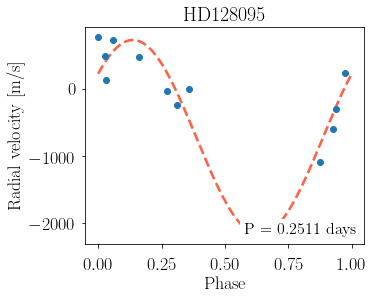

In [90]:
teststar = Star('HD128095', data_dir='/home/anna/Desktop/self_teaching/blog/data/Keck_RVs/')

teststar.find_period(min_period=0.2, max_period=11, print_output=True)
teststar.plot_phased_RVs(num_plots=1)

There are a decent handful of stars with periods shorter than 5 hours. Let's take a look at one of them.

In [76]:
shortPeriod_stars = results[ results['period']<0.21 ]

print(repr(len(shortPeriod_stars)),' with periods < 5 hours')
print(shortPeriod_stars.name)

37  with periods < 5 hours
[b'G244-047' b'GL47' b'HD103847' b'HD11271' b'HD121579' b'HD132173'
 b'HD14651' b'HD150437' b'HD158449' b'HD16559' b'HD174080' b'HD198425'
 b'HD202917' b'HD20439' b'HD20618' b'HD208038' b'HD210392' b'HD215704'
 b'HD31392' b'HD3388-010' b'HD38467' b'HD56303' b'HD72440' b'HD76218'
 b'HD83024' b'HD8328' b'HD87230' b'HD90905' b'HD92222B' b'HD95526'
 b'HIP115332' b'HIP1734' b'HIP32769' b'HIP32919' b'HIP50960' b'HIP59406'
 b'HIP64262']


Best-fitting periods:
P= 0.205012046089  days , power= 0.940280421736
P= 0.206445428997  days , power= 0.918618261237
P= 0.247593619151  days , power= 0.844287281716


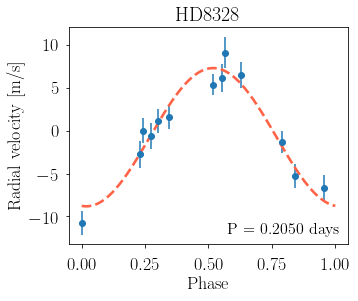

In [73]:
teststar = Star('HD8328', data_dir='/home/anna/Desktop/self_teaching/blog/data/Keck_RVs/')

teststar.find_period(min_period=0.2, max_period=11, print_output=True)
teststar.plot_phased_RVs(num_plots=1)

Only three stars are found with periods greater than 10 days. Let's take a look at one of them.

In [55]:
longPeriod_stars = results[ results['period']>10.]
print(longPeriod_stars.name)

[b'GL4063' b'HD130322' b'HTR170-004']


Best-fitting periods:
P= 10.2371088557  days , power= 0.810520305201
P= 0.30911001105  days , power= 0.780059801835
P= 0.90875371705  days , power= 0.762808766025


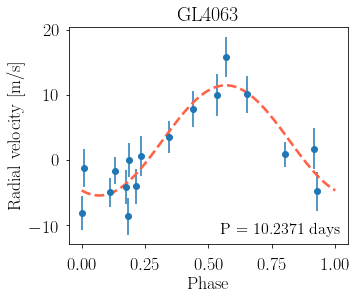

In [71]:
teststar = Star('GL4063', data_dir='/home/anna/Desktop/self_teaching/blog/data/Keck_RVs/')

teststar.find_period(min_period=0.2, max_period=11, print_output=True)
teststar.plot_phased_RVs(num_plots=1)